<a href="https://colab.research.google.com/github/kiran1465313/satellite_sr/blob/main/01_dataset_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p data/div2k
%cd data/div2k
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
!unzip DIV2K_train_HR.zip
!unzip DIV2K_train_LR_bicubic_X4.zip

/content/data/div2k
--2025-06-24 14:37:36--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2025-06-24 14:37:36--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  21.6MB/s    in 2m 37s  

2025-06-24 14:40:14 (21.4 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]

--2025-06-24 14:40:14--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
R

In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git


  Preparing metadata (setup.py) ... done


In [3]:
!pip install tensorflow opencv-python scikit-image matplotlib

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

In [5]:
from tensorflow.keras.layers import Input, Conv2D, Add, Lambda
from tensorflow.keras.models import Model

def res_block(x_in, num_filters):
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Add()([x, x_in])
    return x

def upsample(x, scale, num_filters):
    for _ in range(int(tf.math.log(float(scale)) / tf.math.log(2.0))):
        x = Conv2D(num_filters * 4, 3, padding='same')(x)
        x = Lambda(lambda t: tf.nn.depth_to_space(t, 2))(x)
    return x

def build_edsr(scale=4, num_filters=64, num_res_blocks=16):
    inp = Input(shape=(None, None, 3))
    x = Conv2D(num_filters, 3, padding='same')(inp)
    res = x

    for _ in range(num_res_blocks):
        res = res_block(res, num_filters)

    res = Conv2D(num_filters, 3, padding='same')(res)
    x = Add()([x, res])

    x = upsample(x, scale, num_filters)
    out = Conv2D(3, 3, padding='same')(x)
    return Model(inputs=inp, outputs=out)

model = build_edsr()

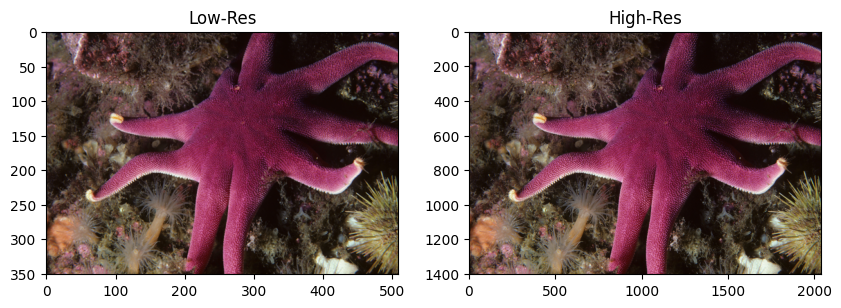

In [6]:
hr_img = cv2.imread('DIV2K_train_HR/0001.png')
lr_img = cv2.imread('DIV2K_train_LR_bicubic/X4/0001x4.png')


lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Low-Res")
plt.imshow(lr_img)
plt.subplot(1,2,2)
plt.title("High-Res")
plt.imshow(hr_img)
plt.show()

In [7]:
# @title scrnn model
# Removed SRCNN model building
# def build_srcnn():
#     model = Sequential()
#     model.add(Conv2D(64, (9, 9), activation='relu', padding='same', input_shape=(None, None, 1)))
#     model.add(Conv2D(32, (1, 1), activation='relu', padding='same'))
#     model.add(Conv2D(1, (5, 5), activation='linear', padding='same'))
#     model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#     return model

In [8]:
#data exraction
import os
import random
from tensorflow.keras.utils import Sequence

class DIV2KDataset(Sequence):
    def __init__(self, lr_dir, hr_dir, patch_size=64, scale=4, batch_size=8, steps_per_epoch=100):
        self.lr_paths = sorted([os.path.join(lr_dir, f) for f in os.listdir(lr_dir)])
        self.hr_paths = sorted([os.path.join(hr_dir, f) for f in os.listdir(hr_dir)])
        self.patch_size = patch_size
        self.scale = scale
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        lr_batch = []
        hr_batch = []
        for _ in range(self.batch_size):
            i = random.randint(0, len(self.lr_paths) - 1)
            lr_img = cv2.imread(self.lr_paths[i])
            hr_img = cv2.imread(self.hr_paths[i])
            lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

            h, w, _ = lr_img.shape
            x = random.randint(0, w - self.patch_size)
            y = random.randint(0, h - self.patch_size)
            lr_patch = lr_img[y:y+self.patch_size, x:x+self.patch_size]
            hr_patch = hr_img[y*self.scale:y*self.scale+self.patch_size*self.scale,
                              x*self.scale:x*self.scale+self.patch_size*self.scale]

            lr_batch.append(lr_patch)
            hr_batch.append(hr_patch)

        return np.array(lr_batch), np.array(hr_batch)

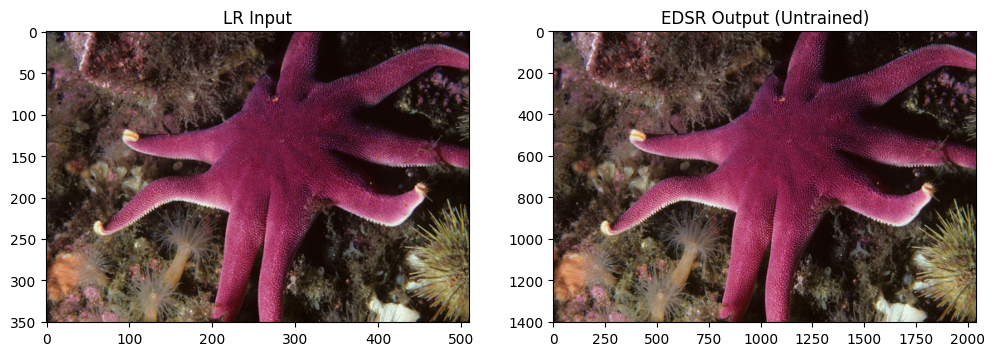

In [11]:
#Testing
lr = cv2.imread('DIV2K_train_LR_bicubic/X4/0001x4.png')
lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
lr = lr.astype(np.float32) / 255.0
lr_input = tf.expand_dims(lr, axis=0)
sr = model(lr_input)
sr = tf.clip_by_value(sr, 0.0, 1.0)
sr_img = tf.squeeze(sr).numpy()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("LR Input")
plt.imshow(lr)
plt.subplot(1, 2, 2)
plt.title("EDSR Output (Trained)")
plt.imshow(sr_img)
plt.show()



In [10]:
#Training
train_gen = DIV2KDataset(
    lr_dir='DIV2K_train_LR_bicubic/X4',
    hr_dir='DIV2K_train_HR',
    patch_size=64,
    scale=4,
    batch_size=8,
    steps_per_epoch=100
)

model.compile(optimizer='adam', loss='mae')
model.fit(train_gen, epochs=10)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 123s 954ms/step - loss: 0.5581
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 929ms/step - loss: 0.0612
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 917ms/step - loss: 0.0502
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 922ms/step - loss: 0.0433
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 926ms/step - loss: 0.0434
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 942ms/step - loss: 0.0406
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 914ms/step - loss: 0.0342
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 917ms/step - loss: 0.0417
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 959ms/step - loss: 0.0402
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 938ms/step - loss: 0.0401
